### Part of EECS 6893 - Big Data Analytics - Fall 2021 - Final Project 

* Group ID:- 202112-53
* Title:- Assaying MSD
* Contributors:- Karpagam Murugappan; Arya Kasulla

Year Prediction using Linear Regression and Multinomial Logistic Regression

In [1]:
! pip install pyspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 41.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=00d5295ef1995a4cb50f0d4818bd87058a983020215146874ab18f888ae2b459
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [1]:
import os
from pyspark import SparkConf                                                                                                                 
from pyspark.context import SparkContext                                                                                                      
from pyspark.sql import SparkSession, SQLContext
from pyspark import *
from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

plt.rcParams['font.size']= 15

In [ ]:
#Create year dict
fileObj = open(os.getcwd()+"/data/YearPredictionMSD/YearPredictionMSD.txt", "r")
years = set()
for line in fileObj.readlines():
    label = int(line[:4])
    years.add(label)
yr_dict={}
ct=0
for y in years:
    yr_dict[y] = ct
    ct+=1

In [ ]:
fileObj = open(os.getcwd()+"/data/YearPredictionMSD/YearPredictionMSD.txt", "r")
lines = []

ct = 0
for line in fileObj.readlines():
    
    label = int(line[:4])
    idx = yr_dict[label]
    txt=''
    txt+=str(idx)
    txt+=' '
    cc = 0
    for v in line.split(',')[1:13]:
        cc+=1
        txt+=str(cc)
        txt+=':'
        txt+=v
        txt+=' '
      
      
    lines.append(txt)
    ct+=1
fileObj.close()

with open(os.getcwd()+'/data/reg_data_12_features.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [2]:
'''
Create spark context and session
'''
sc = SparkContext('local')
spark = SparkSession(sc)

#### Linear Regression

In [3]:
#dataset = spark.read.csv(os.getcwd()+"/data/YearPredictionMSD.txt", header=False, inferSchema=True)
dataset = spark.read.csv("/content/YearPredictionMSD.txt", header=False, inferSchema=True)

# Using MinMax Scaler to scale 12 features - first column is label - year
vassembler = VectorAssembler(inputCols=dataset.columns[1:], outputCol="features")
data1 = vassembler.transform(dataset)
scaler = MinMaxScaler(inputCol='features', outputCol='feat_scaled')
scalermodel = scaler.fit(data1)
data2 = scalermodel.transform(data1)
data3 = data2.select(F.col('_c0').alias('label'), F.col('feat_scaled').alias('features'))

'''
80% Training : 20% Testing split; random seed 227
'''
train, test = data3.randomSplit([0.8,0.2], seed = 227)

In [11]:
'''
regularization parameter 0.3
50 iterations
'''
lr= LinearRegression(featuresCol = 'features', labelCol='label', maxIter=50, regParam=0.3,elasticNetParam=0.8)

# Fit the model
lr_model = lr.fit(train)
training_summary = lr_model.summary

# RMSE error
print("RMSE:- ", training_summary.rootMeanSquaredError)

#Get training error evolution
objhis = training_summary.objectiveHistory
training_error_df = pd.DataFrame(columns=['step', 'training_error'])
ct = 0

for obj in objhis:
    ct += 1
    training_error_df = training_error_df.append({'step': ct, 'training_error': 10 ** (obj)}, ignore_index=True)

RMSE:-  9.555613954299925


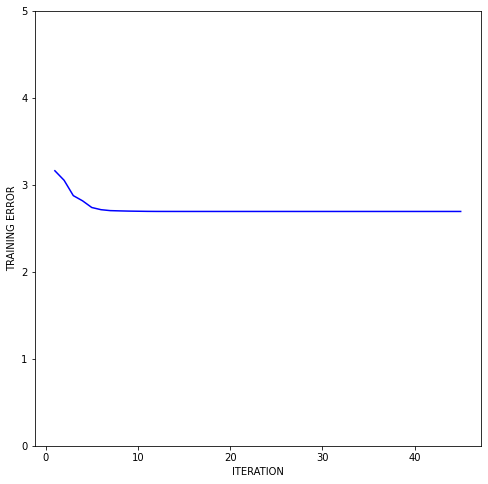

In [8]:
plt.figure(figsize=(8,8))   
plt.plot(training_error_df['step'], training_error_df['training_error'],color='blue')
plt.ylim(0,5)
plt.xlabel('ITERATION')
plt.ylabel('TRAINING ERROR')
plt.show()

In [11]:
predictions = lr_model.transform(test)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
print("Testing RMSE:- ", evaluator.evaluate(predictions))

Testing RMSE:-  9.739253241501773


#### Multinomial Logistic Regression

In [ ]:
'''
Read the input in LibSVM format
'''
dataset = spark.read.format("libsvm").load(os.getcwd()+"/data/reg_data_12_features.txt")

In [ ]:
'''
80% Training : 20% Testing split; random seed 100
'''
train, test = dataset.randomSplit([0.8, 0.2], seed = 100)

In [ ]:
'''
regularization parameter 0.3
10 iterations
'''
lr = LogisticRegression(maxIter=10, regParam=0.3)

# Fit the model
log_model = lr.fit(train)

# Coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(log_model.coefficientMatrix))
print("Intercept: " + str(log_model.interceptVector))

training_summary = log_model.summary

# Evaluation metrics
print("False positive rate by label:")
for i, rate in enumerate(training_summary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(training_summary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(training_summary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(training_summary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(training_summary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = training_summary.accuracy
falsePositiveRate = training_summary.weightedFalsePositiveRate
truePositiveRate = training_summary.weightedTruePositiveRate
fMeasure = training_summary.weightedFMeasure()
precision = training_summary.weightedPrecision
recall = training_summary.weightedRecall
print("Accuracy:- %s\nFPR:- %s\nTPR:- %s\nF-measure:- %s\nPrecision:- %s\nRecall:- %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


Coefficients: 
DenseMatrix([[-1.76551462e-06,  1.46313750e-07,  2.06855491e-07, ...,
              -4.76183213e-06, -3.29518134e-06, -4.24193217e-06],
             [-6.00804561e-06, -1.58391972e-06,  2.73548716e-06, ...,
               7.20958180e-06,  9.29684987e-06,  4.78056183e-06],
             [-1.15817539e-05, -2.33182281e-06,  4.01197356e-06, ...,
               1.09816484e-05,  2.04075100e-05,  5.55120074e-06],
             ...,
             [ 8.00325535e-03, -1.44122644e-04, -4.87278617e-04, ...,
               2.60387318e-04,  1.29210340e-03, -1.19602295e-03],
             [ 2.64324422e-03, -8.62964018e-05, -1.89851189e-04, ...,
              -1.61305445e-04,  1.36416231e-03, -5.68520437e-04],
             [ 1.72701887e-06,  2.29068252e-08,  1.14784247e-07, ...,
              -2.23426301e-08,  7.82058587e-07,  3.76270156e-07]])
Intercept: [-4.50047472743144,-4.682734965156961,-4.345986435185328,-3.5826887633442444,-2.7920140345539997,-2.4804846285160234,-1.967510027827266,-2.

In [ ]:
#Testing
predictions = log_model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
print("Testing Accuracy:- " +str(accuracy))

Testing Accuracy:- 0.07599088926958418


#### Reload the dataset and select records in the year 1990 to 2010 i.e. label > 70 - data with high number of records

In [ ]:
'''
Read the input in LibSVM format
'''
dataset = spark.read.format("libsvm").load(os.getcwd()+"/data/reg_data_12_features.txt")
d1 = dataset.filter(dataset.label > '70')

In [ ]:
d1.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 78.0|(12,[0,1,2,3,4,5,...|
| 84.0|(12,[0,1,2,3,4,5,...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
'''
80% Training : 20% Testing split; random seed 235
'''
train, test = d1.randomSplit([0.8, 0.2], seed = 235)

In [ ]:
'''
regularization parameter 0.23
10 iterations
'''
lr = LogisticRegression(maxIter=10, regParam=0.23)

# Fit the model
log_model = lr.fit(train)

# Coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(log_model.coefficientMatrix))
print("Intercept: " + str(log_model.interceptVector))

training_summary = log_model.summary

# Evaluation metrics
print("False positive rate by label:")
for i, rate in enumerate(training_summary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(training_summary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(training_summary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(training_summary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(training_summary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = training_summary.accuracy
falsePositiveRate = training_summary.weightedFalsePositiveRate
truePositiveRate = training_summary.weightedTruePositiveRate
fMeasure = training_summary.weightedFMeasure()
precision = training_summary.weightedPrecision
recall = training_summary.weightedRecall
print("Accuracy:- %s\nFPR:- %s\nTPR:- %s\nF-measure:- %s\nPrecision:- %s\nRecall:- %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


Coefficients: 
DenseMatrix([[ 1.77526345e-08,  6.06811064e-10,  4.34770297e-10, ...,
              -4.37676958e-09,  4.51627754e-09, -6.80096660e-09],
             [ 1.77526345e-08,  6.06811064e-10,  4.34770297e-10, ...,
              -4.37676958e-09,  4.51627754e-09, -6.80096660e-09],
             [ 1.77526345e-08,  6.06811064e-10,  4.34770297e-10, ...,
              -4.37676958e-09,  4.51627754e-09, -6.80096660e-09],
             ...,
             [ 7.63084433e-03, -2.02646638e-04, -1.56002963e-04, ...,
               1.53675141e-05,  1.70004921e-03, -5.11278088e-04],
             [ 2.59535829e-03, -1.30561289e-04, -4.82144073e-05, ...,
              -5.28937006e-04,  2.20610190e-03, -2.74694832e-04],
             [ 2.67111861e-06,  3.96592533e-08,  2.27036256e-07, ...,
              -7.57967115e-08,  1.27897382e-06,  7.33863815e-07]])
Intercept: [-1.870481220713539,-1.870481220713539,-1.870481220713539,-1.870481220713539,-1.870481220713539,-1.870481220713539,-1.870481220713539,-1.87

In [ ]:
#Testing
predictions = log_model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
print("Testing Accuracy:- " +str(accuracy))

Testing Accuracy:- 0.09972295680644755


In [ ]:
predictions.filter(predictions.label > '85').show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704810740507...|[3.18461987510666...|      83.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704808216143...|[3.21406033189982...|      83.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704809171308...|[3.19766757546525...|      83.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704806554973...|[3.26860972304081...|      86.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704804999717...|[3.15981228911582...|      84.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704807052505...|[3.18510026519851...|      84.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704811657942...|[3.24779072004378...|      83.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704806050788...|[3.21054427586435...|      83.0|
| 86.0|(12,[0,1,2,3,4,5,...|[-1.8704806126200...|[3.27885465828350...|      84.0|
| 86.0|(12,[0,1,